In [1]:
import pandas as pd
import datetime
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from midas.mix import mix_freq, mix_freq2
from midas.adl import estimate, forecast, midas_adl, rmse, estimate2, forecast2, midas_adl2

from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = {'png', 'retina'}
import japanize_matplotlib

In [2]:
pd.set_option('display.max_row', 10)

In [3]:
import warnings
warnings.filterwarnings(action='ignore')

In [4]:
# 拠点データ
car = pd.read_csv('alternative_car_polygon_master.csv')
# 人流データ
cav = pd.read_csv('alternative_cav.csv')
# date_flgをdatetime型に
cav['date_flg'] = pd.to_datetime(cav['date_flg'])
# polygon_idとdate_flgでソート
cav = cav.sort_values(['polygon_id', 'date_flg'])

In [5]:
# 銘柄コードと企業名の辞書を作成
car_dict = dict(zip(car['stock_code'].unique(), car['stock_name'].unique()))
# poligon_id でマージする
df_merge = pd.merge(cav, car, on='polygon_id', how='left')
# 最後の月はデータが１月分なく、月次データ予測に向かないので除く
df_merge = df_merge[df_merge['date_flg']<'2022-08']

In [6]:
# 生産台数データの読み込み
production = pd.read_csv('production.csv')
# Dateをdatetime型に
production['Date'] = pd.to_datetime(production['Date'], format='%Y%m')
# Dateをindexに
production = production.set_index('Date')
# カラムの銘柄コードをintに
production.columns = production.columns.astype(int)
# 日付を月末にする
production = production.resample('M').sum()

In [7]:
# trainは 2018/1 ~ 2021/8 の 44か月
# testは 2021/9 ~ 2022/7 の 11か月
start_date = production.index[0]
end_date = datetime.datetime(2021,9,30)

In [8]:
def get_df_pca(stock_code):
    # 銘柄で絞り込む
    df = df_merge[df_merge['stock_code']==stock_code]
    # 日次で集計
    df = df[['date_flg', 'stay_time_complement','place_name']].groupby(['place_name','date_flg']).sum(['stay_time_complement'])
    # dfを横持ちにする
    df = df.unstack(level=0).fillna(1)['stay_time_complement']
    # 2022/5/31 （火）がおかしい？
    # とりあえず前後の平均で補間する
    df.loc['2022-05-31'] = (df.loc['2022-05-30'] + df.loc['2022-06-01'])/2

    # 主成分分析
    # 標準化
    ss_df = StandardScaler()
    df_std = ss_df.fit_transform(df)
    #主成分分析の実行
    pca = PCA()
    pca.fit(df_std)
    # データを主成分に変換
    data_pca = pca.transform(df_std)
    # データフレームに
    df_pca = pd.DataFrame(index=df.index,
                          columns=["PC{}".format(x + 1) for x in range(len(df.columns))],
                          data=data_pca)

    # 週次にしたものも作る
    df_pca_w = df_pca.resample('W').sum()
    
    return df_pca, df_pca_w

In [9]:
def midas_predict(df_tgt, lag):
    hf1 = df_tgt.iloc[:,0]
    hf2 = df_tgt.iloc[:,1]
    lf = production[stock_code]
    
    # Mixing Frequencies
    y, yl, x1, x2, yf, ylf, x1f, x2f = mix_freq2(lf, hf1, hf2, lag, lag, 1, 2,
                                                 start_date=start_date,
                                                 end_date=end_date)
    # Fitting the Model
    res = estimate2(y, yl, x1, x2, poly1='expalmon', poly2='expalmon')
    # Forecasting
    y, yl, x1, x2, yf, ylf, x1f, x2f = mix_freq2(lf, hf1, hf2, lag, lag, 1, 2)
    fc = forecast2(x1, x2, yl, res, poly1='expalmon',poly2='expalmon')
    forecast_df = fc.join(lf)
    
    train = forecast_df[forecast_df.index<=end_date]
    test = forecast_df[forecast_df.index>end_date]
    
    # 描画
    plt.figure(figsize=(12, 6))
    plt.plot(forecast_df[stock_code], label='actual')
    plt.plot(train['yfh'], label='train_pred')
    plt.plot(test['yfh'], label='test_pred')
    plt.legend()
    plt.title(f'生産台数の実測値と予測値\n{stock_code} {car_dict[stock_code]}')
    plt.show()
    
    # 評価
    # r2_score （sklearn を使わずに）
    r2_train = train.corr().values[1][0]**2
    r2_test = test.corr().values[1][0]**2

    # MAPE
    mape_train = mape(train[stock_code], train['yfh'])
    mape_test = mape(test[stock_code], test['yfh'])

    print('train')
    print(f'R2 = {r2_train}')
    print(f'MAPE = {mape_train}')
    print('test')
    print(f'R2 = {r2_test}')
    print(f'MAPE = {mape_test}')

#### (仮説)
1か月＝30日ではないのでずれる  
1か月＝４週ではないのでずれる  
→ 精度が下がる  
ずれないようにするには  
1か月をすべて k分割して数を揃える  

In [10]:
def midas_predict2(df_pca, k): # １か月を k分割して数を揃える
    df_pca['Ym'] = df_pca.index.strftime("%Y-%m")

    df_new_list = []

    for Ym in df_pca['Ym'].unique():
        df = df_pca[df_pca['Ym']==Ym]
        del df['Ym']

        # 等分割したindex
        idx_div = np.array_split(df.index, k)

        data_list = []
        idx_list = []
        for idx in idx_div:
            df_div = df.loc[idx]
            data_list.append(list(df_div.sum(axis=0)))
            if len(idx)>0:
                idx_list.append(df_div.index[0])
            else:
                idx_list.append(np.nan)
        df_new = pd.DataFrame(data=data_list, index=idx_list, columns=df.columns)
        df_new_list.append(df_new)

    df_pca_new = pd.concat(df_new_list)
    
    # 上記で作った df_pca_newをもとに midasを適用
    midas_predict(df_pca_new, k)

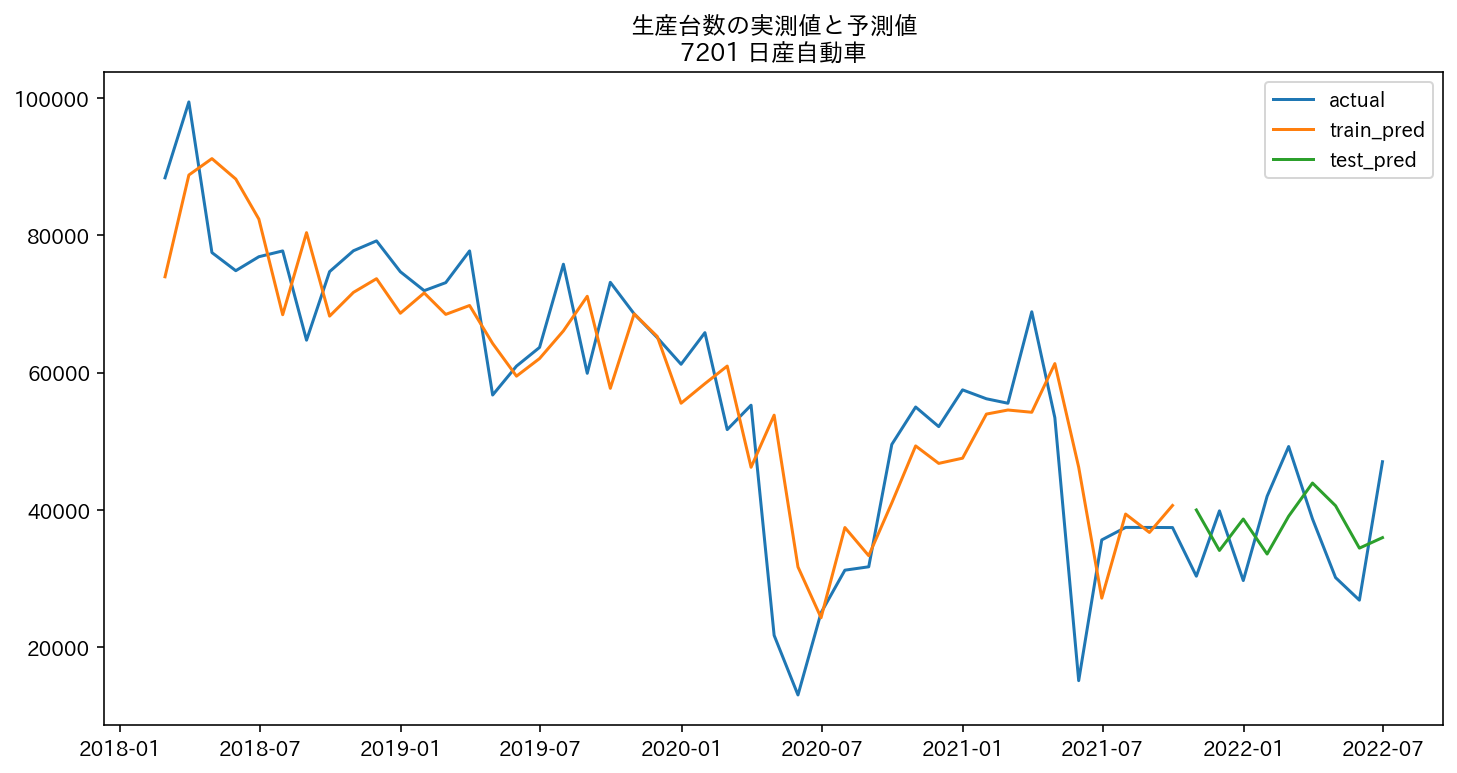

train
R2 = 0.7010653483246783
MAPE = 0.21450123761384007
test
R2 = 0.0172243151186347
MAPE = 0.24174406351619926


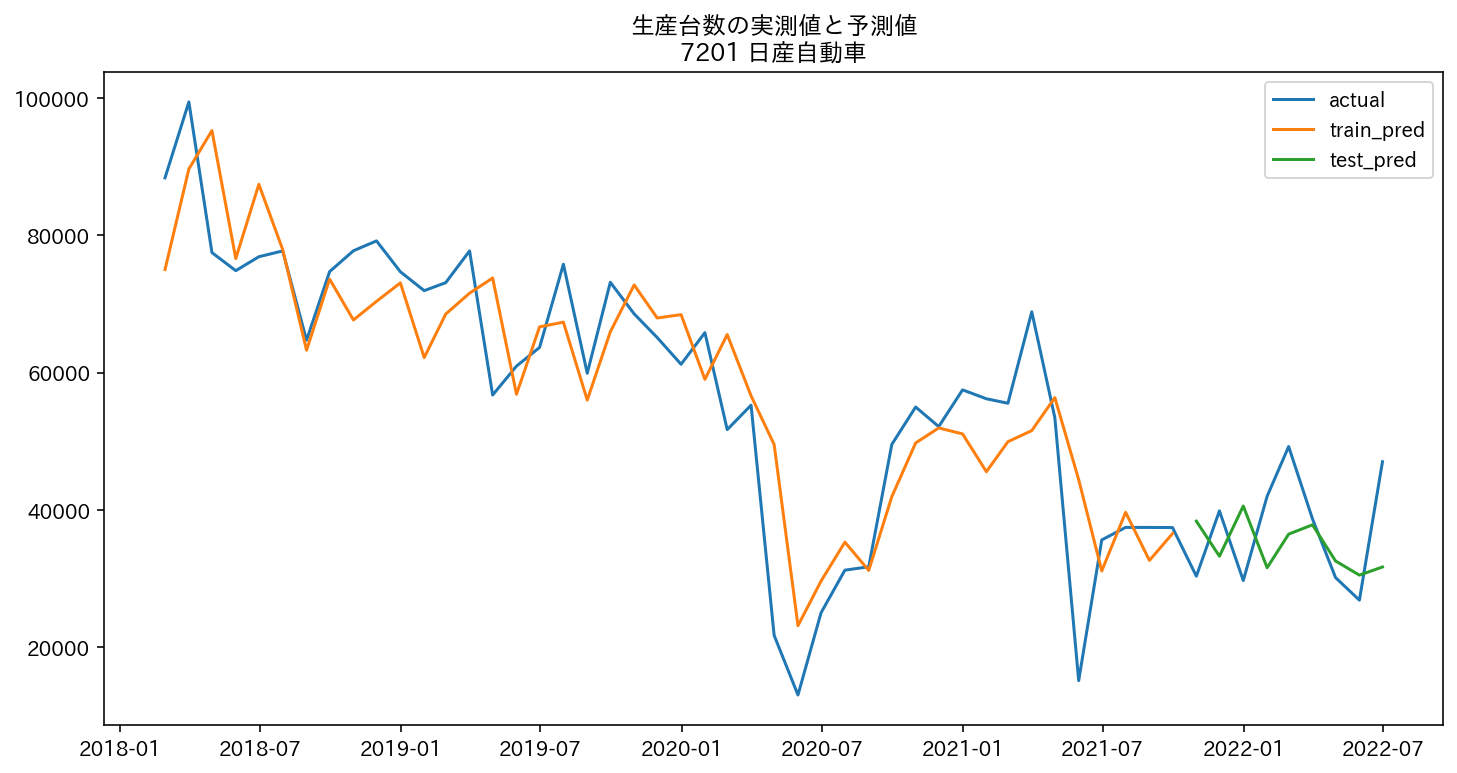

train
R2 = 0.7500240124213547
MAPE = 0.1857540220734812
test
R2 = 0.01940168169314381
MAPE = 0.2078831567850333


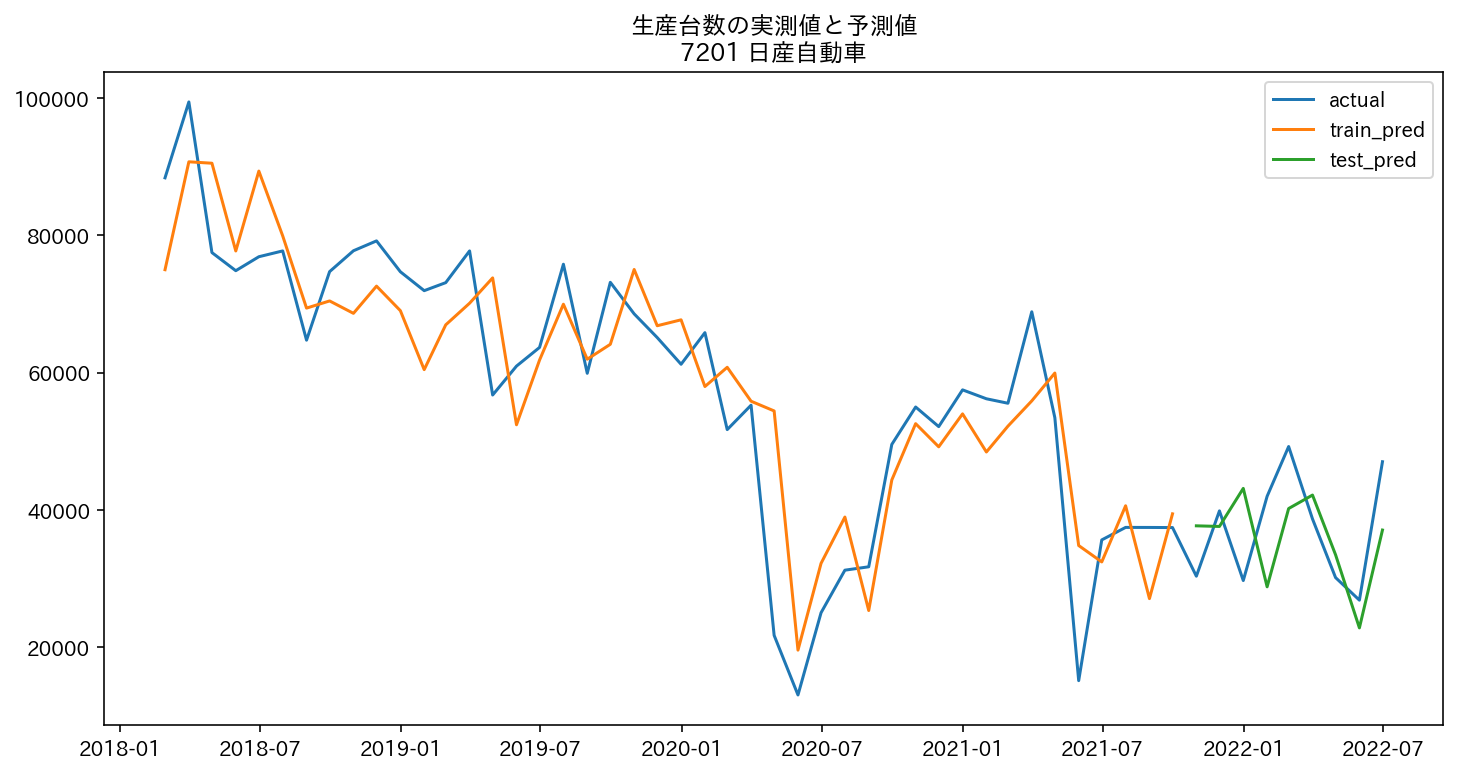

train
R2 = 0.7712381482120675
MAPE = 0.18100080349469513
test
R2 = 0.09075415119890747
MAPE = 0.20160967401436897
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------


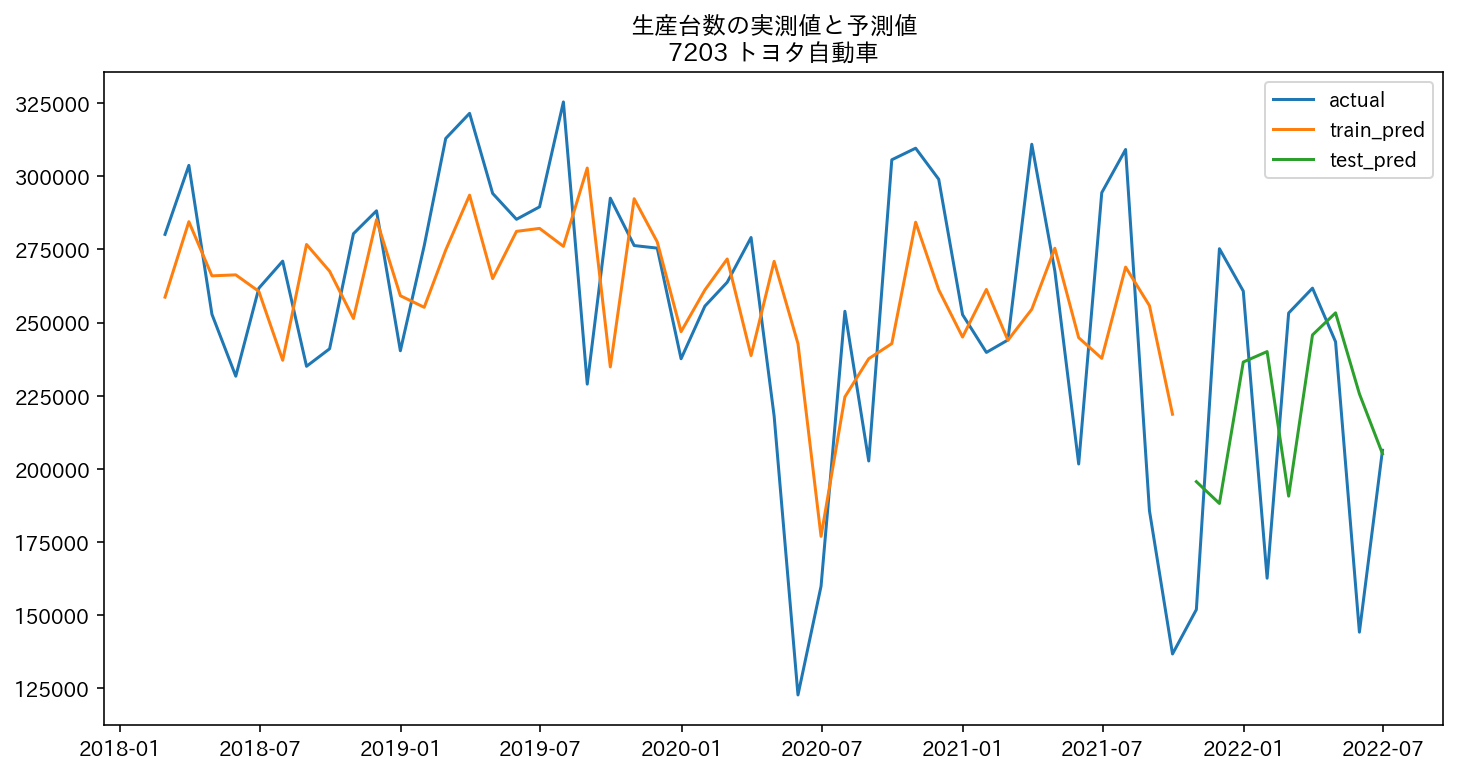

train
R2 = 0.24040474777314608
MAPE = 0.1413032771525395
test
R2 = 5.626654581676938e-05
MAPE = 0.232524461449193


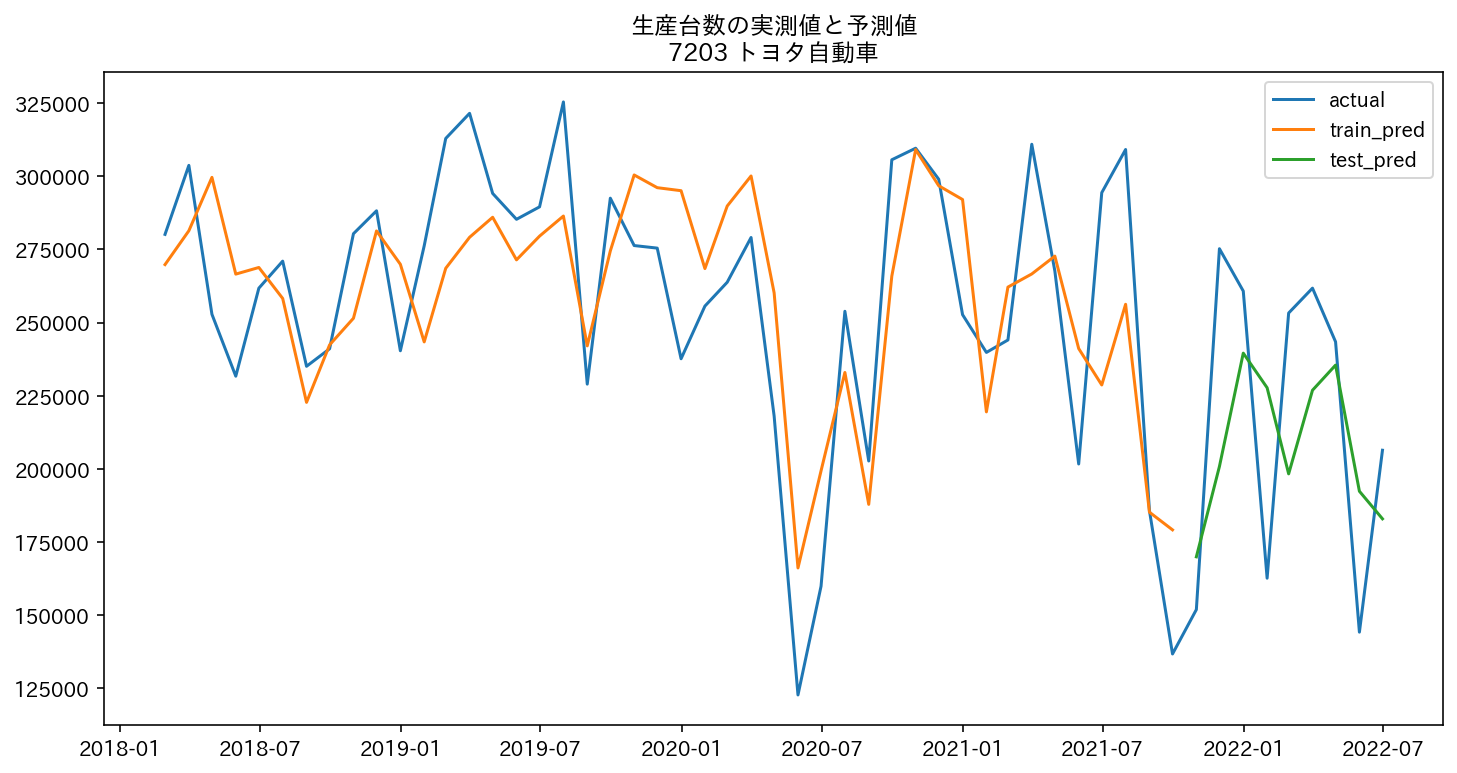

train
R2 = 0.5630043411761353
MAPE = 0.10601611382268822
test
R2 = 0.22894123888463927
MAPE = 0.18900314629765916


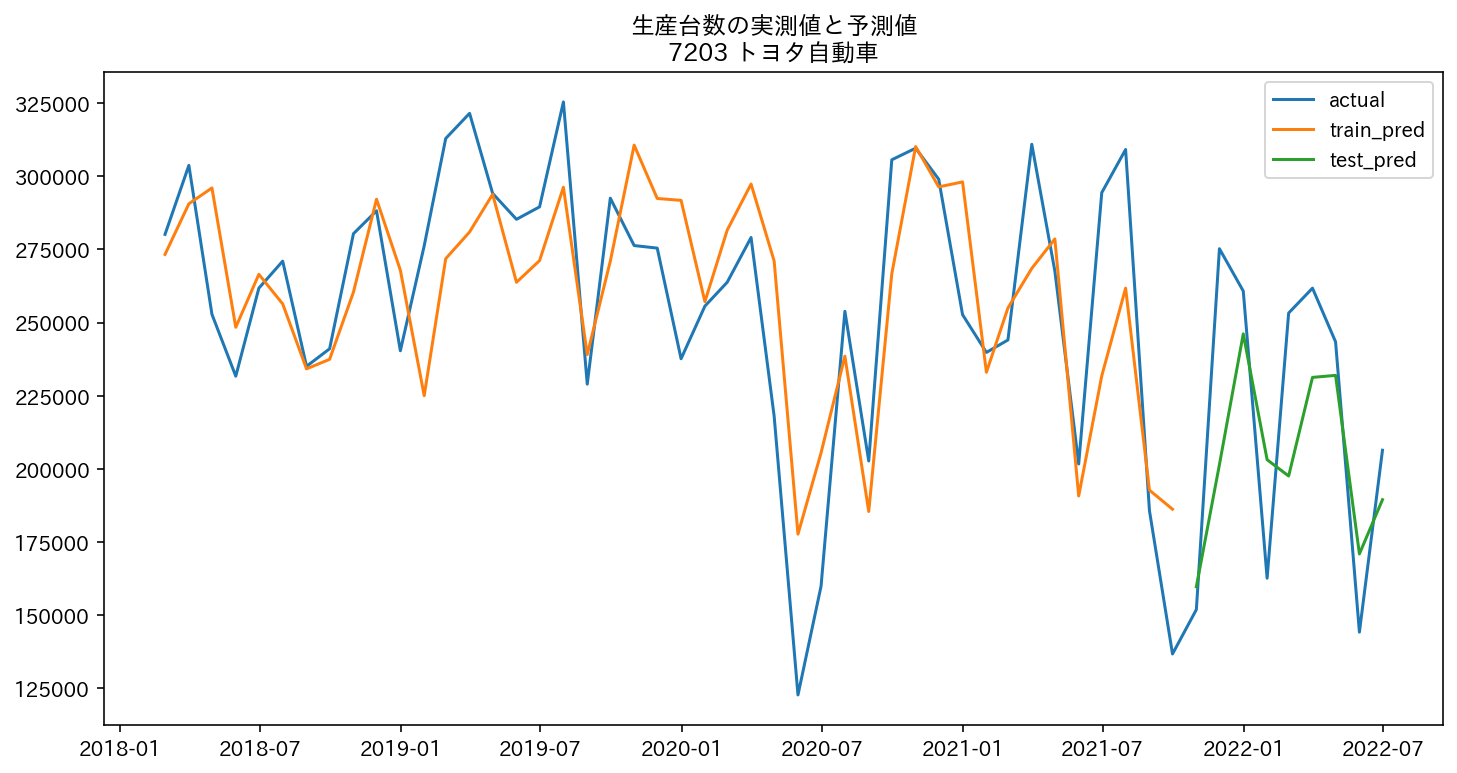

train
R2 = 0.5763668805980169
MAPE = 0.1011799372963438
test
R2 = 0.5484221459527296
MAPE = 0.14168362419083202
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------


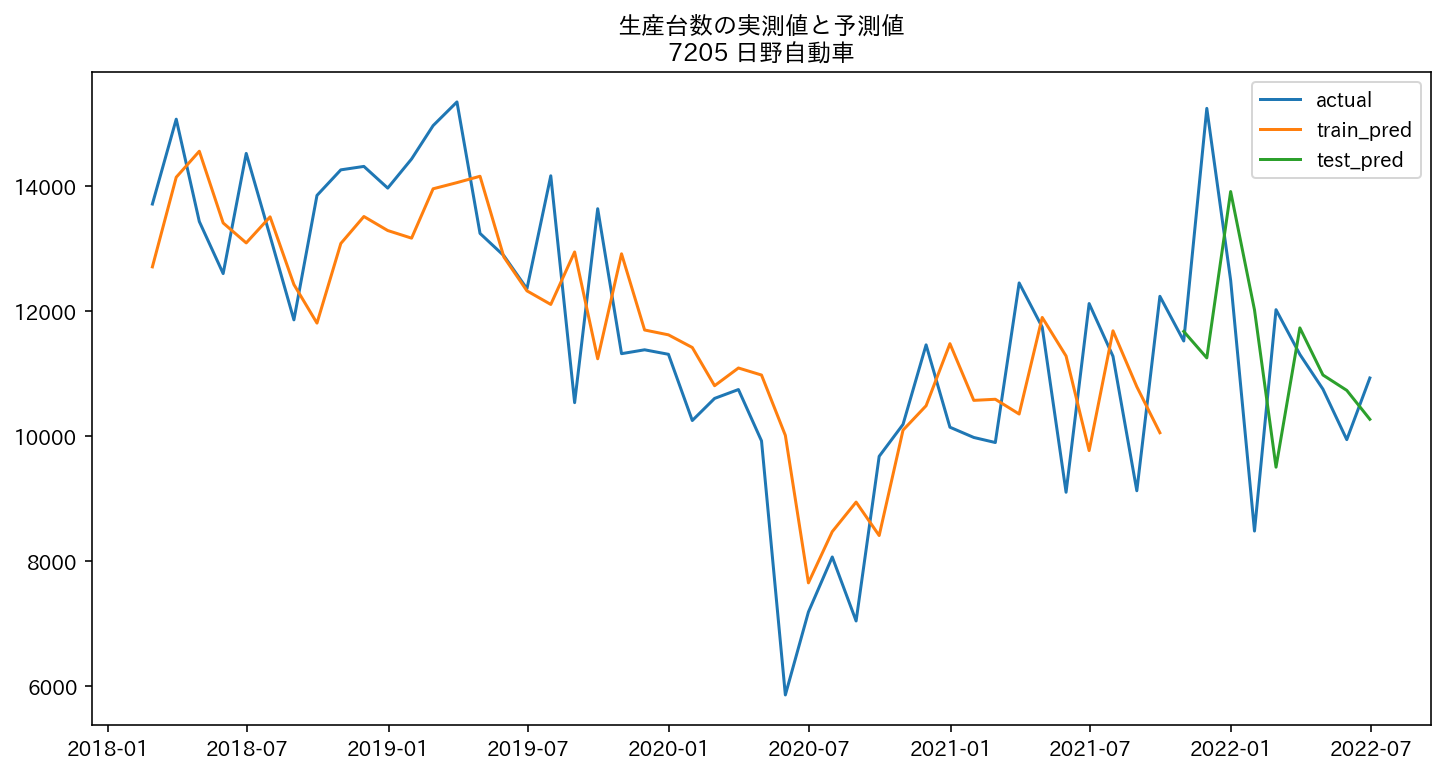

train
R2 = 0.6133953599165233
MAPE = 0.10704535126414307
test
R2 = 0.002742603455304237
MAPE = 0.13488448269588416


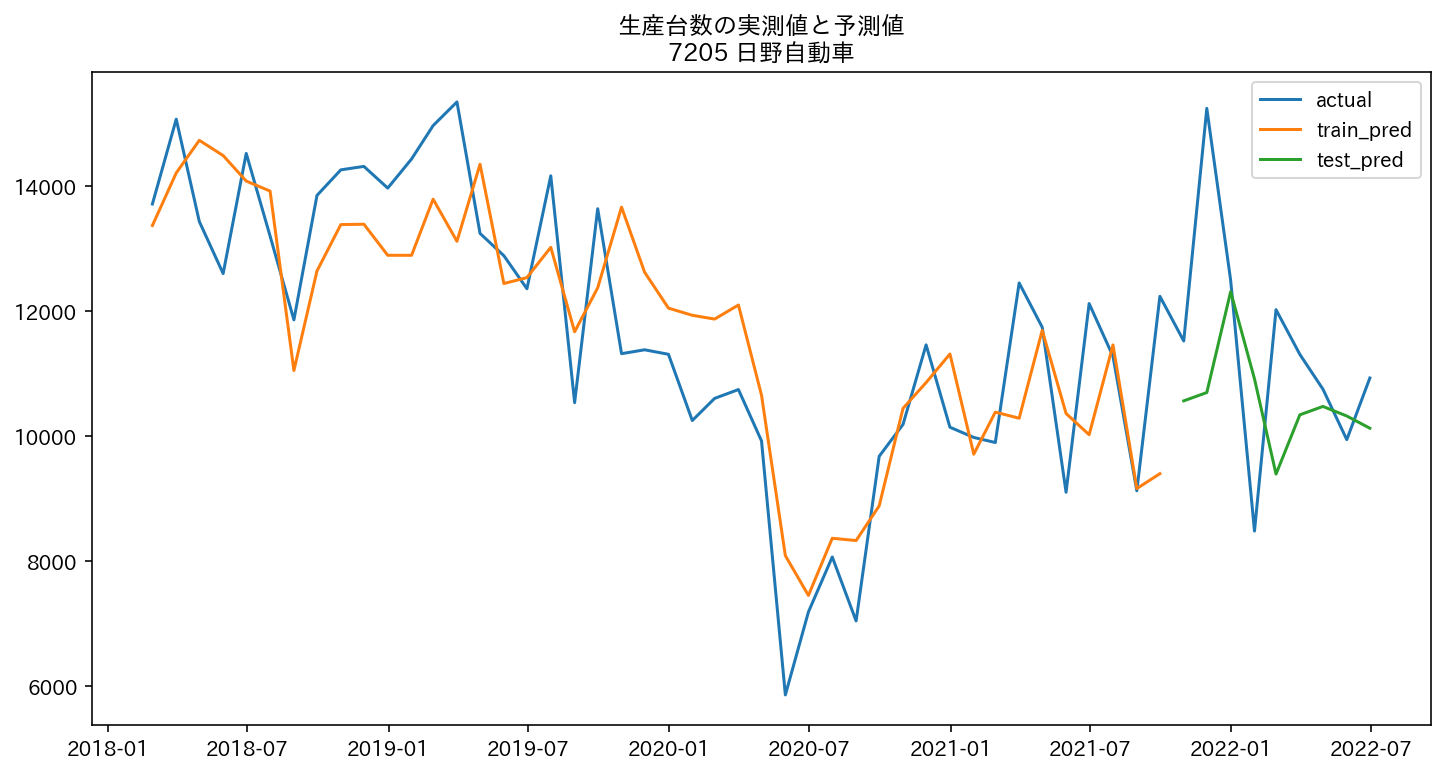

train
R2 = 0.6960546755858443
MAPE = 0.09343993739872043
test
R2 = 0.012616950917022767
MAPE = 0.12491636030700959


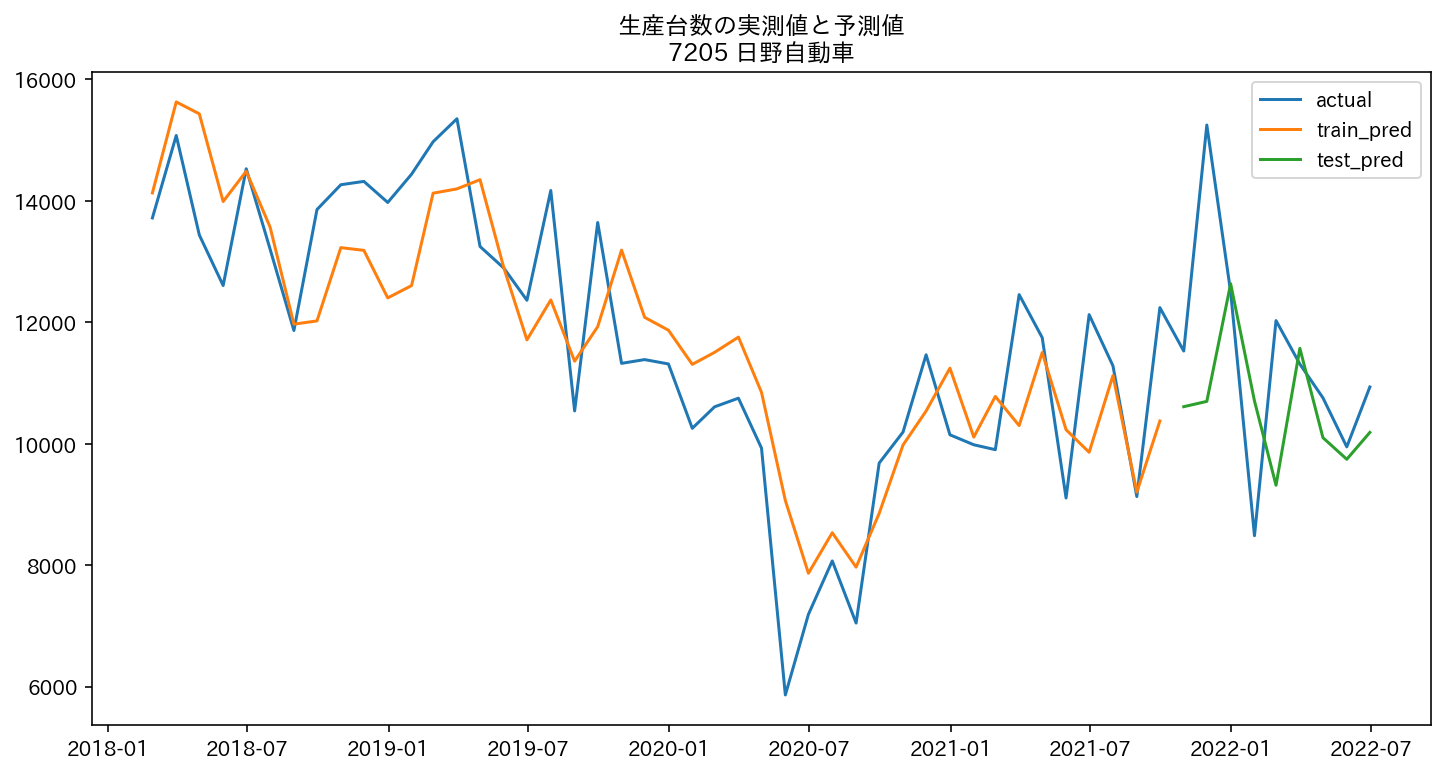

train
R2 = 0.7056288711778849
MAPE = 0.09179855654528914
test
R2 = 0.04593757616234444
MAPE = 0.11656177739359148
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------


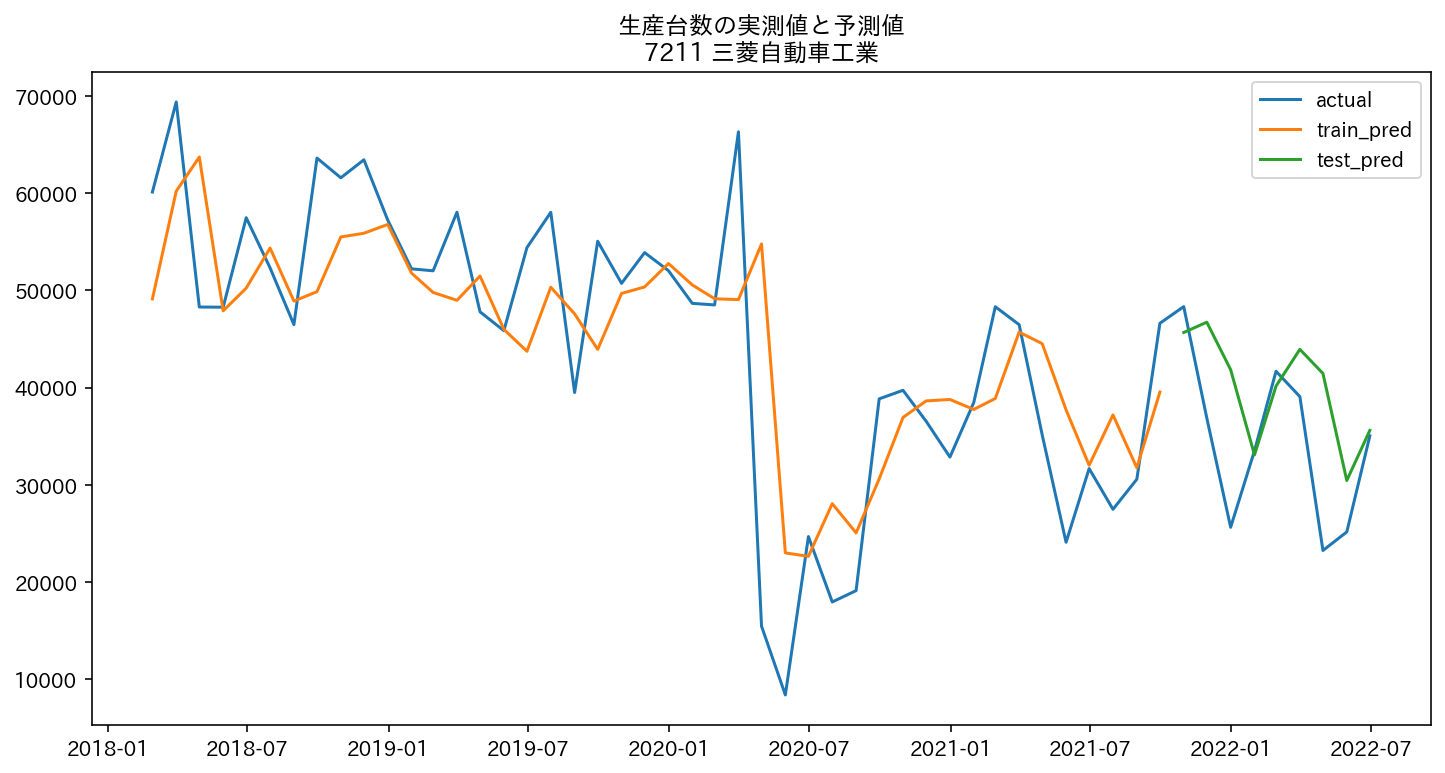

train
R2 = 0.5533681194658296
MAPE = 0.2298881069001273
test
R2 = 0.21021682624502994
MAPE = 0.2376492605283317


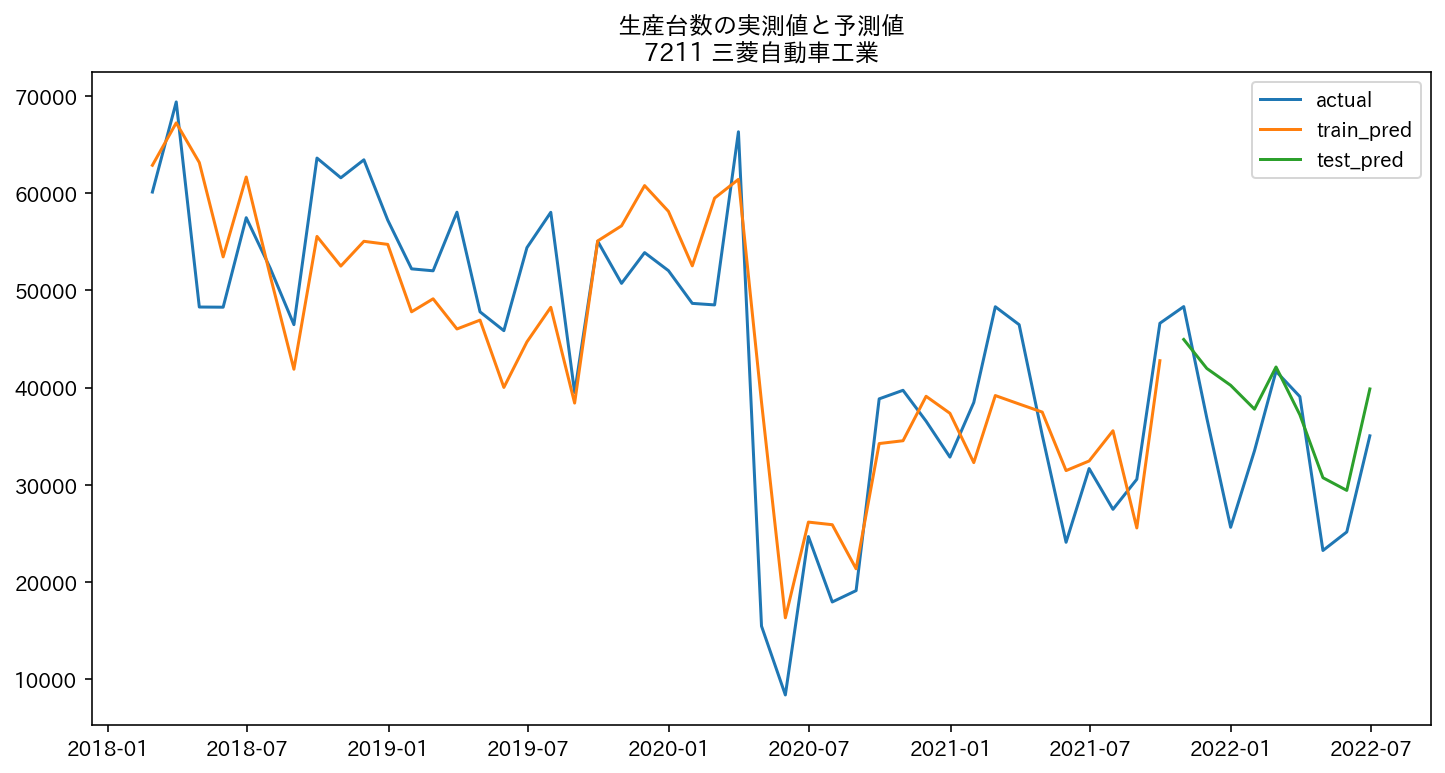

train
R2 = 0.7473286138855559
MAPE = 0.17528201948819191
test
R2 = 0.6235501753482131
MAPE = 0.17714769410206818


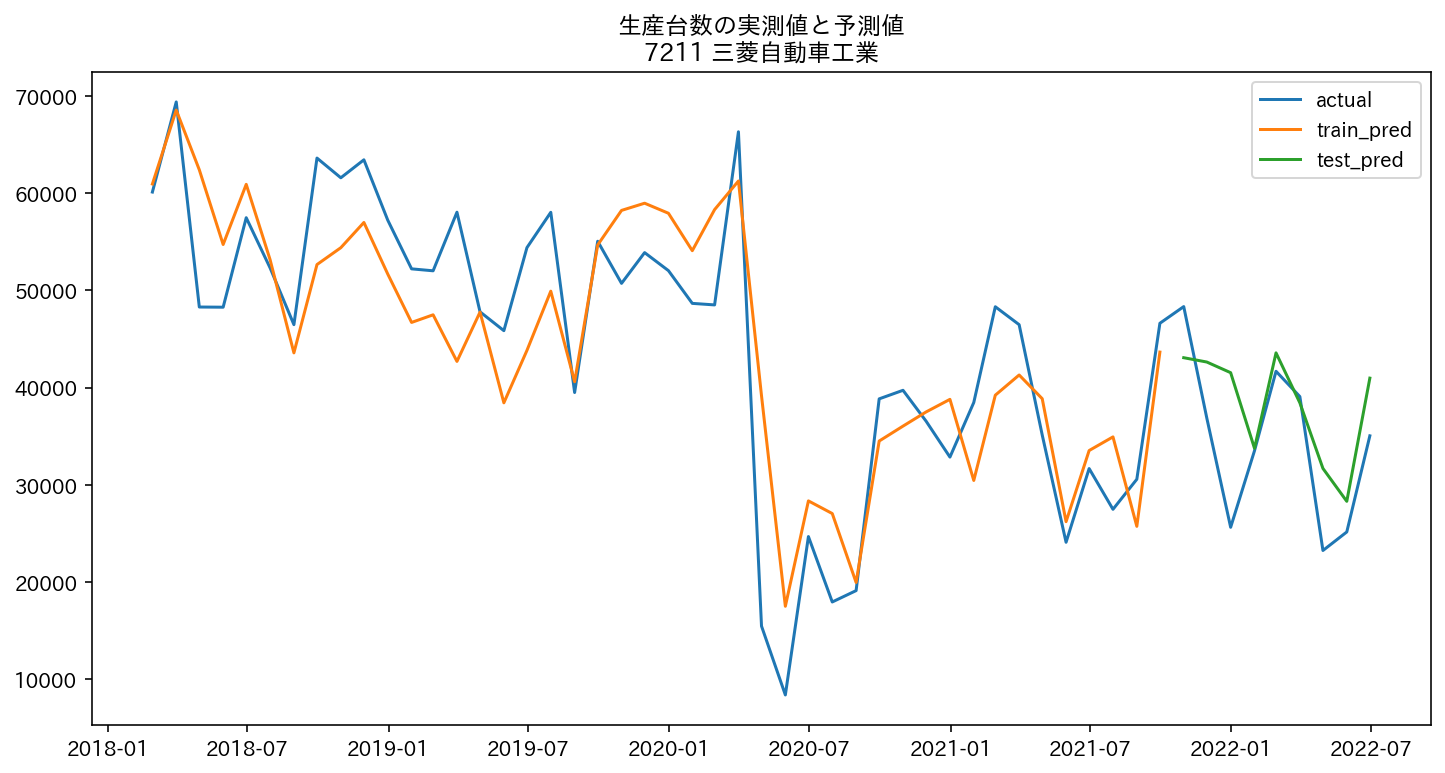

train
R2 = 0.7367140057127411
MAPE = 0.17717786656339382
test
R2 = 0.4770575125255559
MAPE = 0.1792352518787514
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------


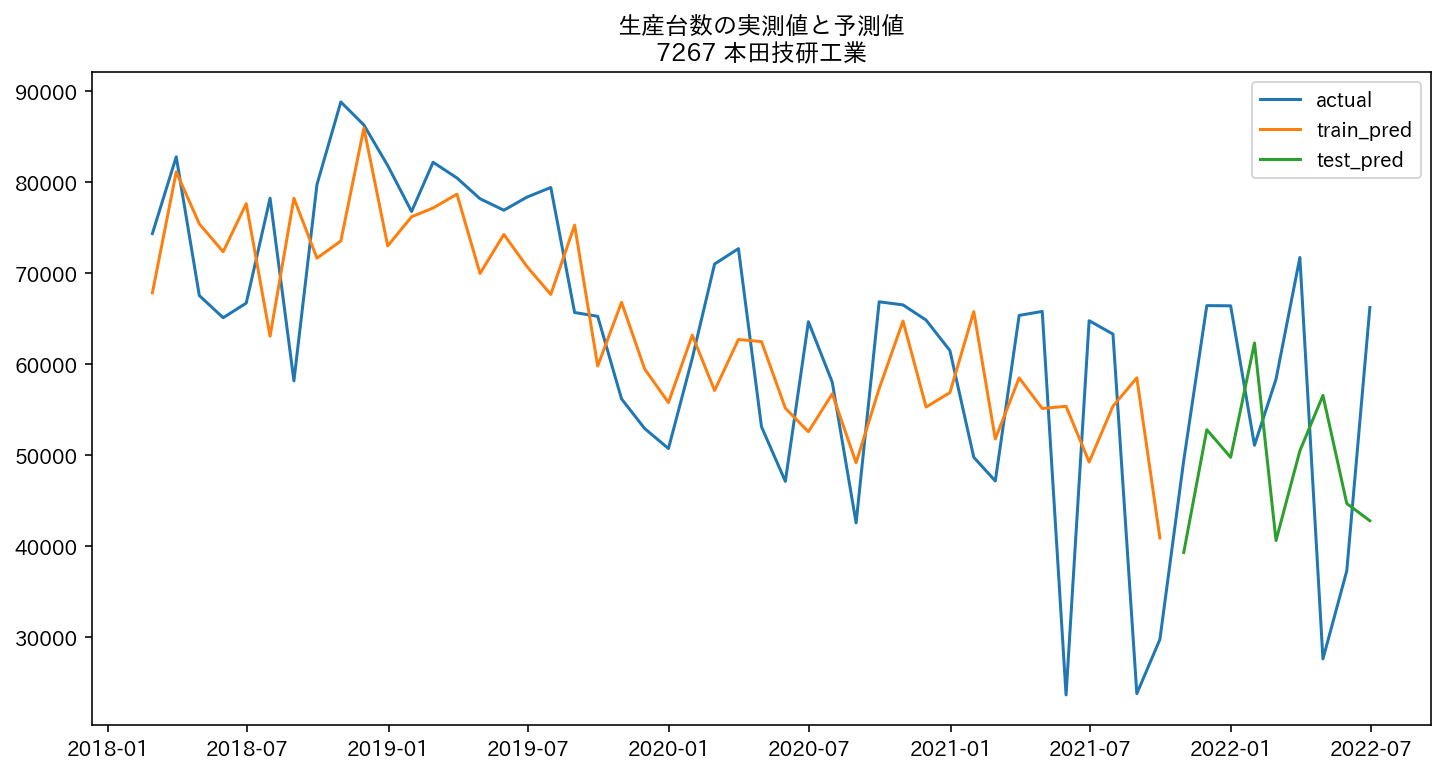

train
R2 = 0.4347836040115164
MAPE = 0.18743629957030492
test
R2 = 0.026569821807071688
MAPE = 0.34253286098489827


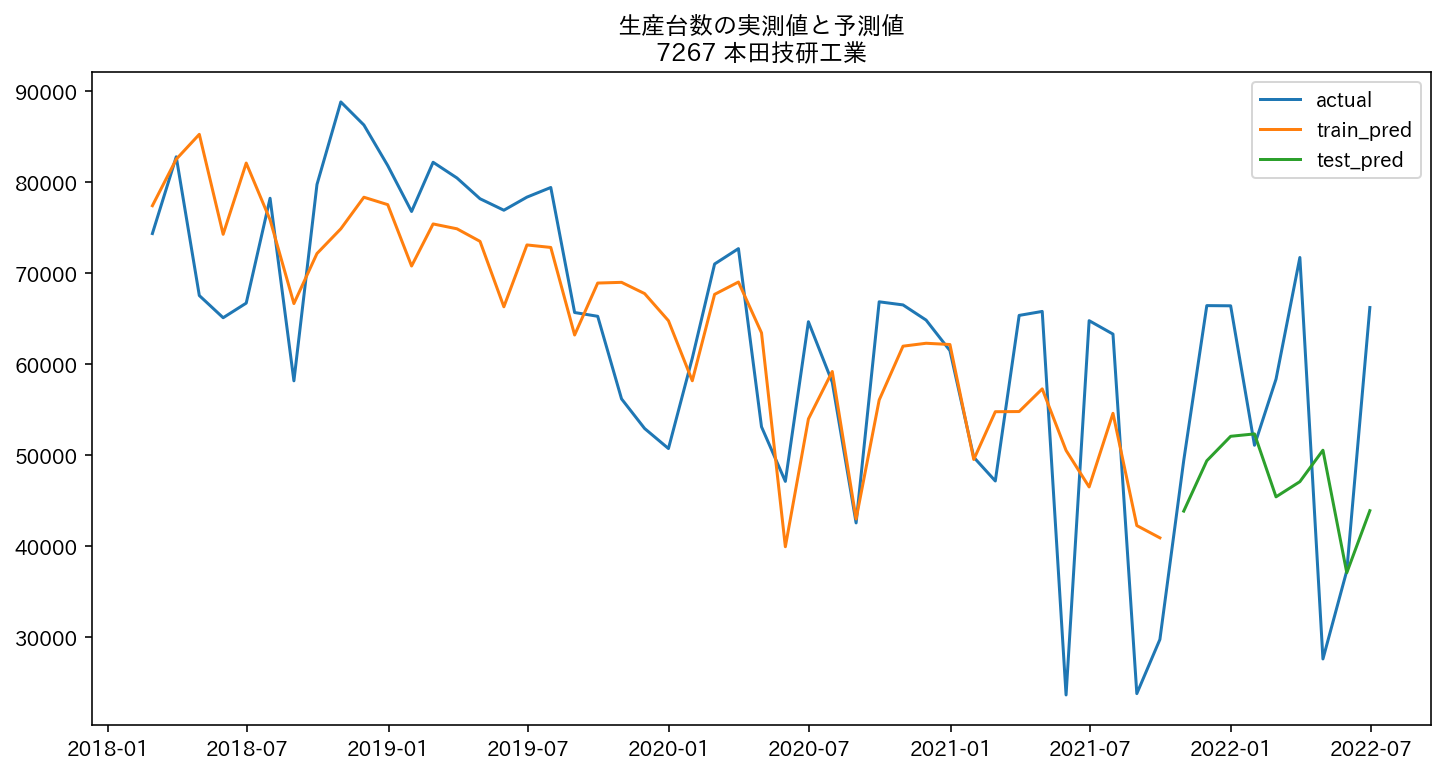

train
R2 = 0.5859434426102994
MAPE = 0.15532151411879713
test
R2 = 0.043024664942511656
MAPE = 0.2610060898678683


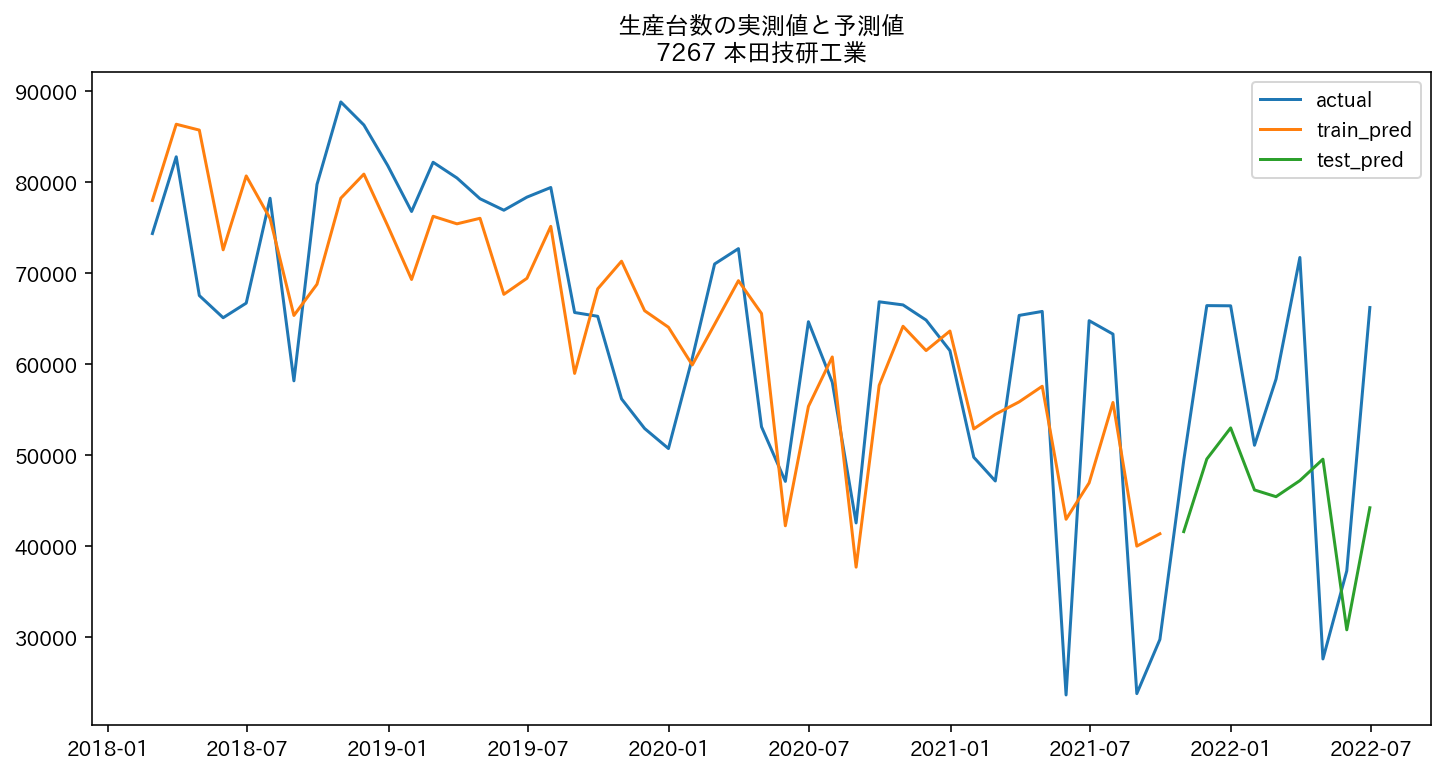

train
R2 = 0.6380016793113761
MAPE = 0.14859952564560458
test
R2 = 0.1697320155180718
MAPE = 0.28615574541560995
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------


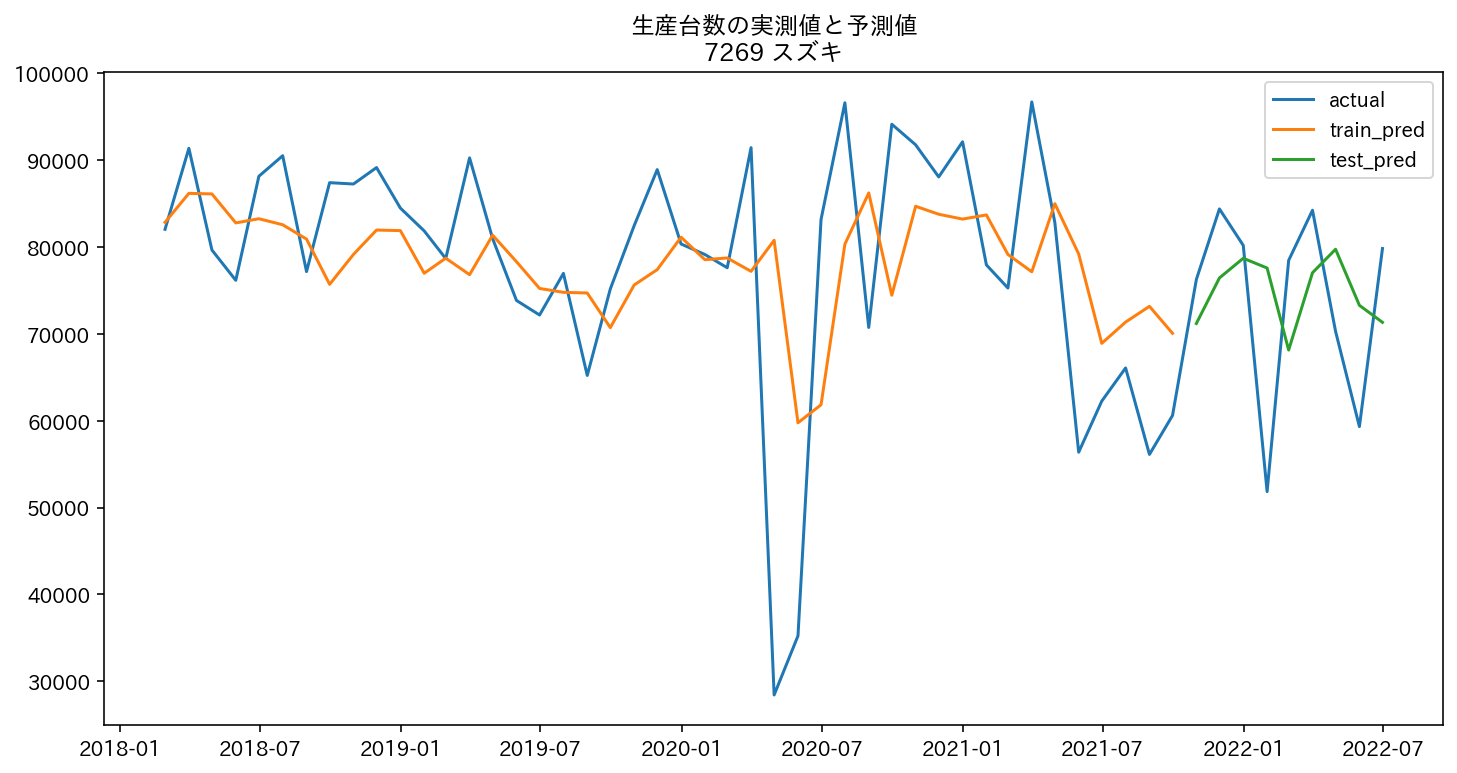

train
R2 = 0.1724267656405864
MAPE = 0.1530602502313591
test
R2 = 0.02045803522332906
MAPE = 0.1521224616637176


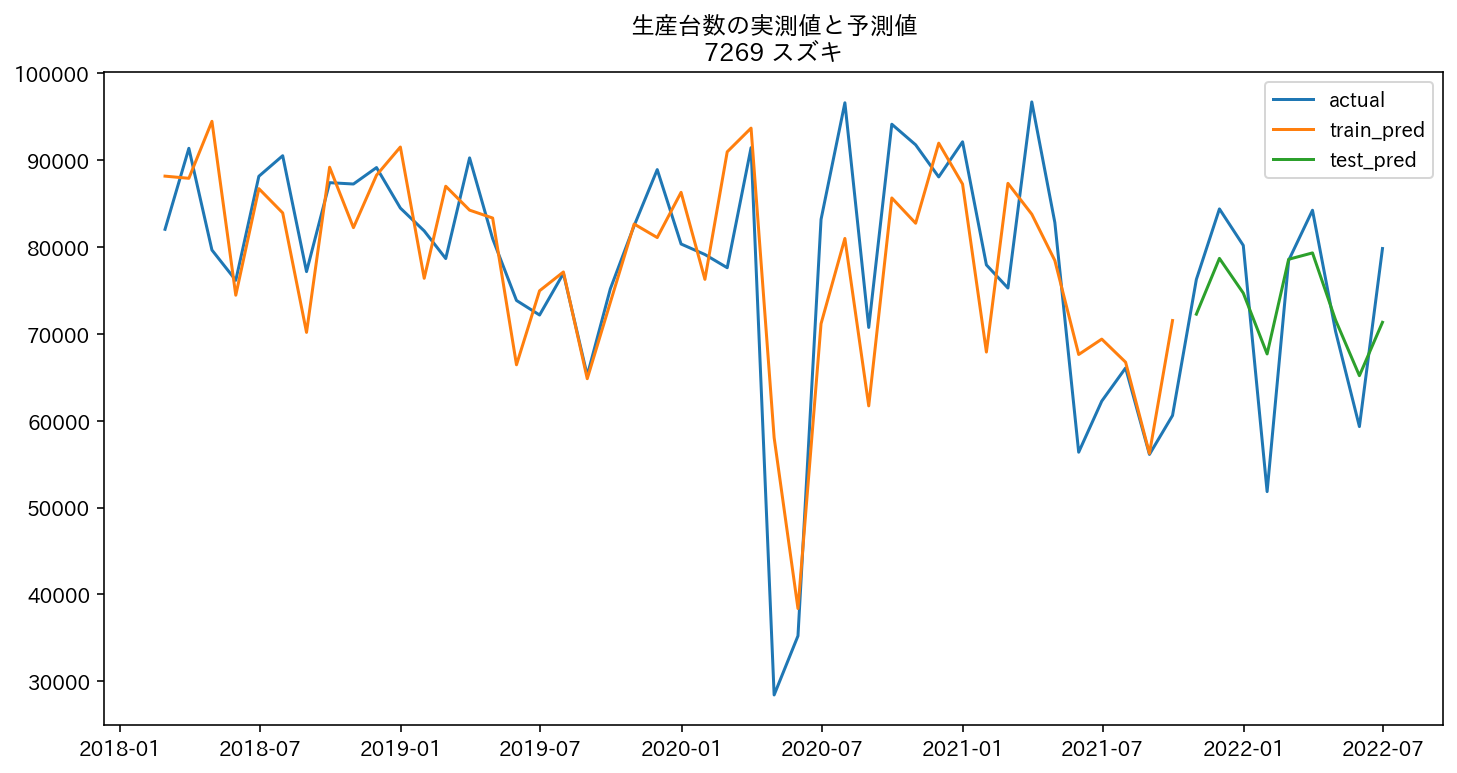

train
R2 = 0.6426426238763988
MAPE = 0.09859918457264961
test
R2 = 0.7209057452768247
MAPE = 0.08642352129525782


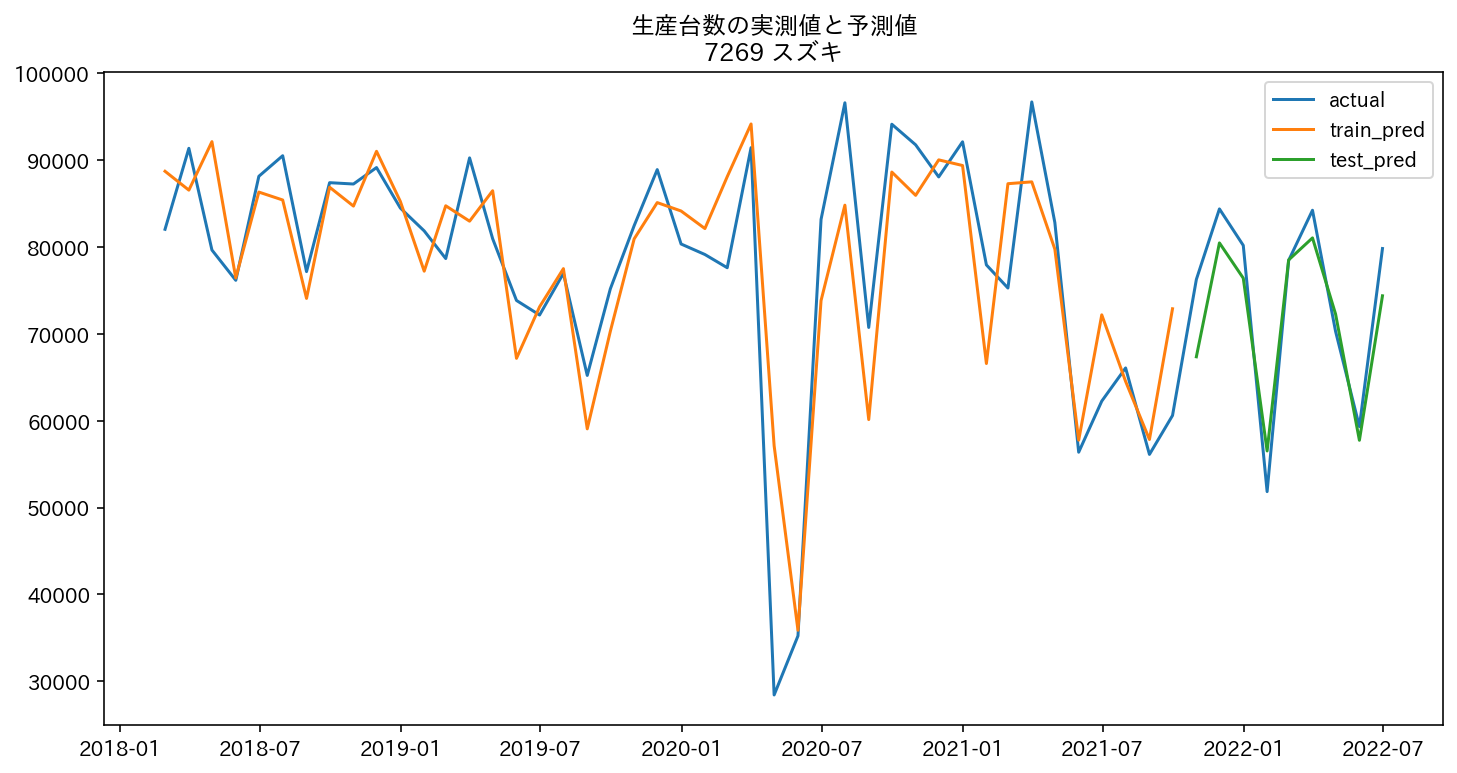

train
R2 = 0.7177590622427324
MAPE = 0.08647594214602541
test
R2 = 0.8877346220051923
MAPE = 0.05134716889917954
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------


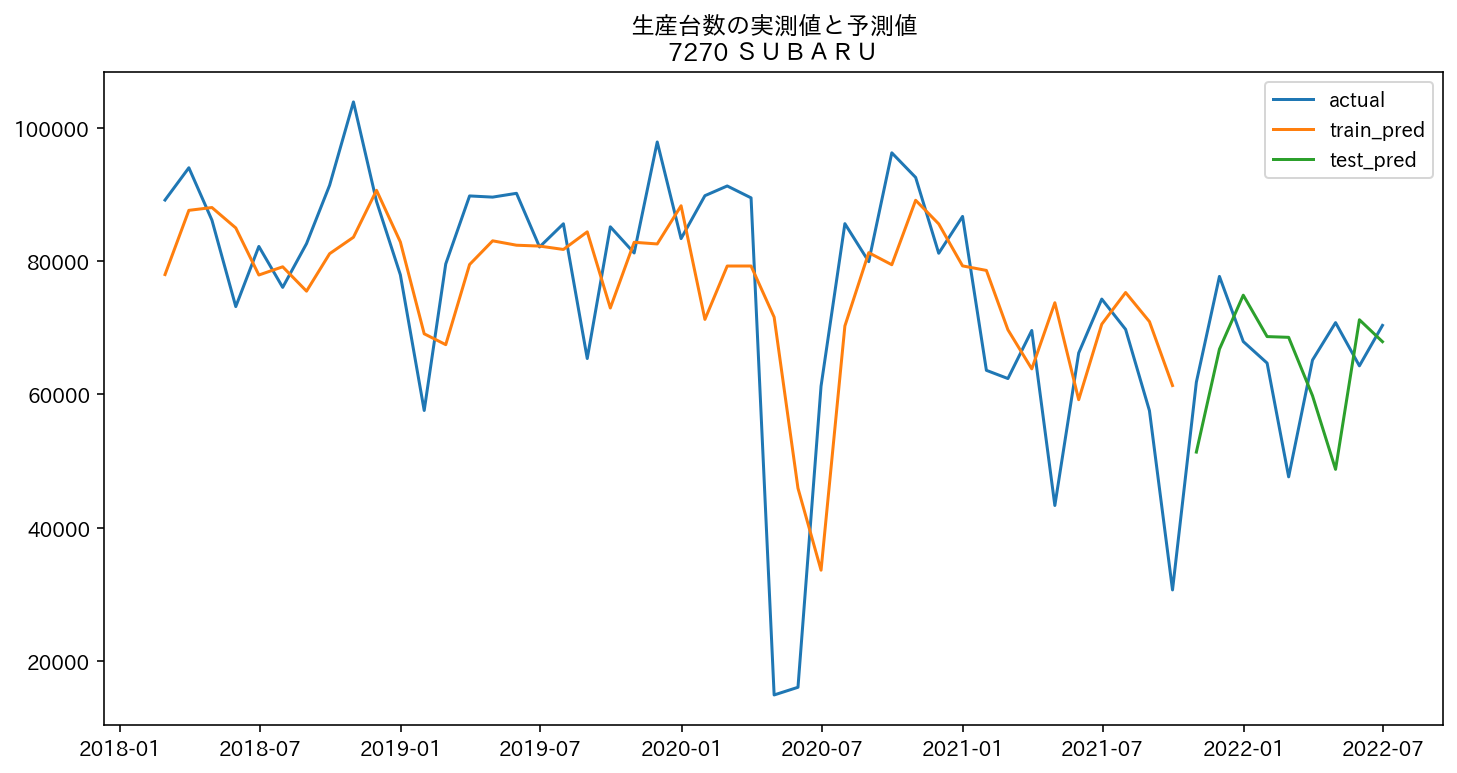

train
R2 = 0.3618262261961519
MAPE = 0.27277217992518604
test
R2 = 0.0064026518410596235
MAPE = 0.16096956147623026


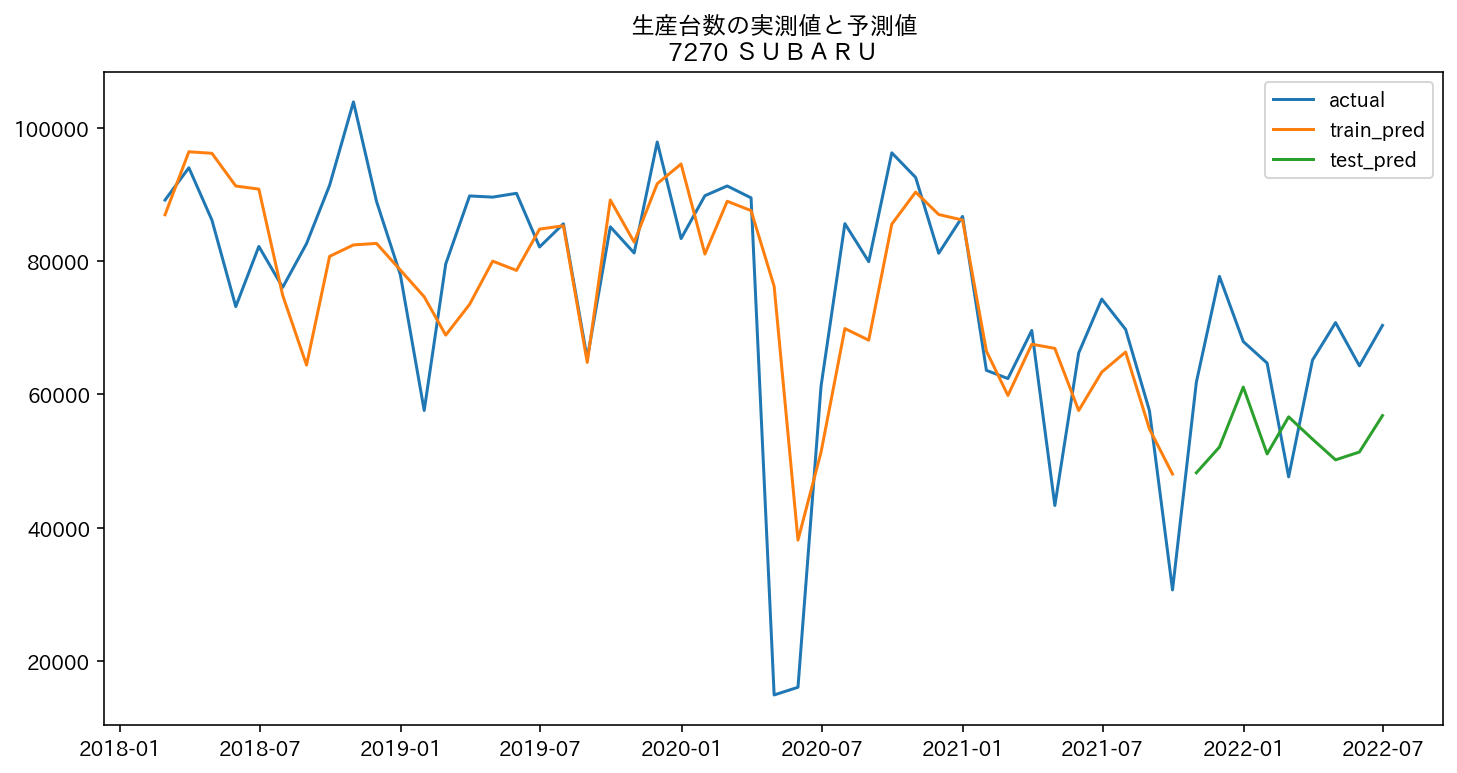

train
R2 = 0.48606643890211637
MAPE = 0.23297799683942175
test
R2 = 0.014523731148192744
MAPE = 0.2128822831142837


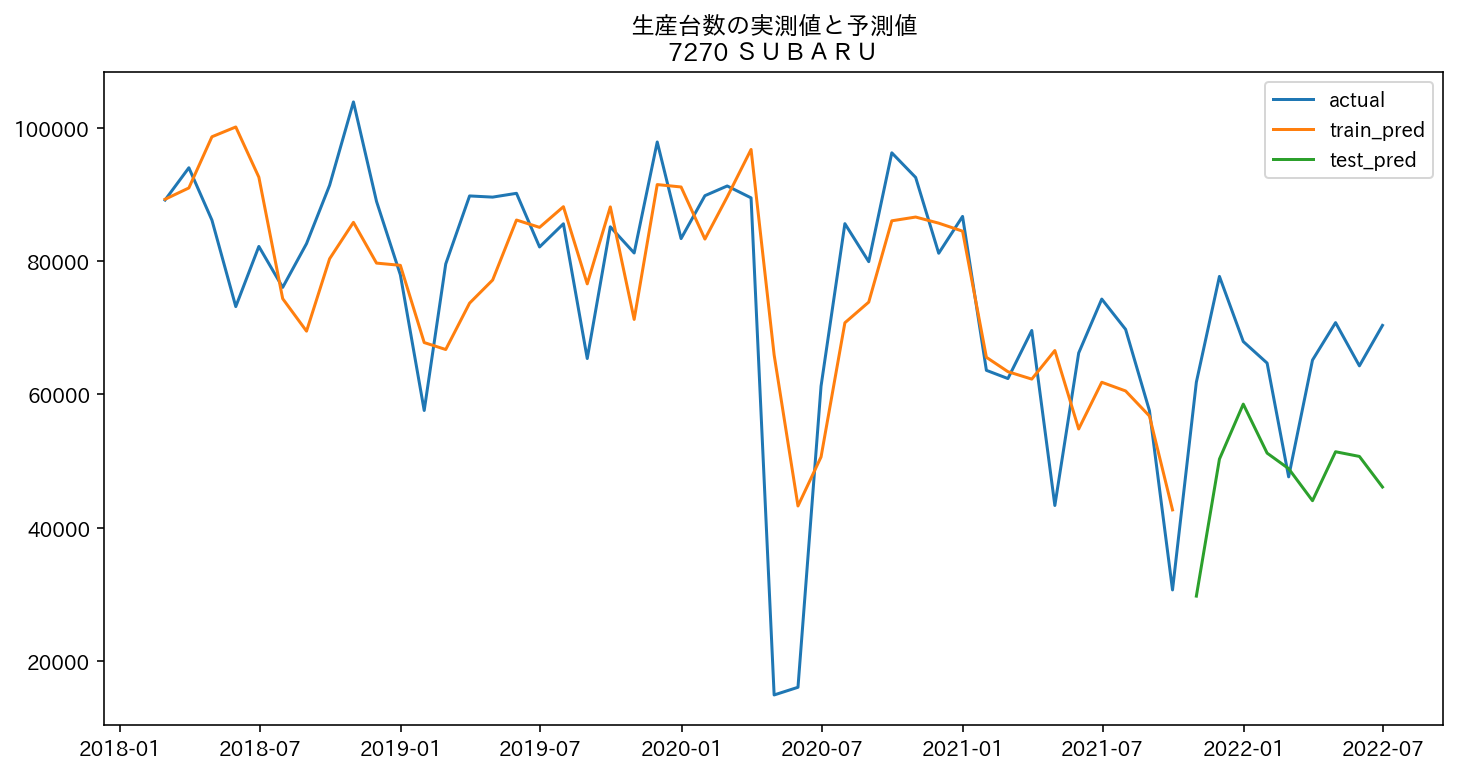

train
R2 = 0.5313765103271204
MAPE = 0.22842776834895287
test
R2 = 0.044476482901173064
MAPE = 0.26644774414781525
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------


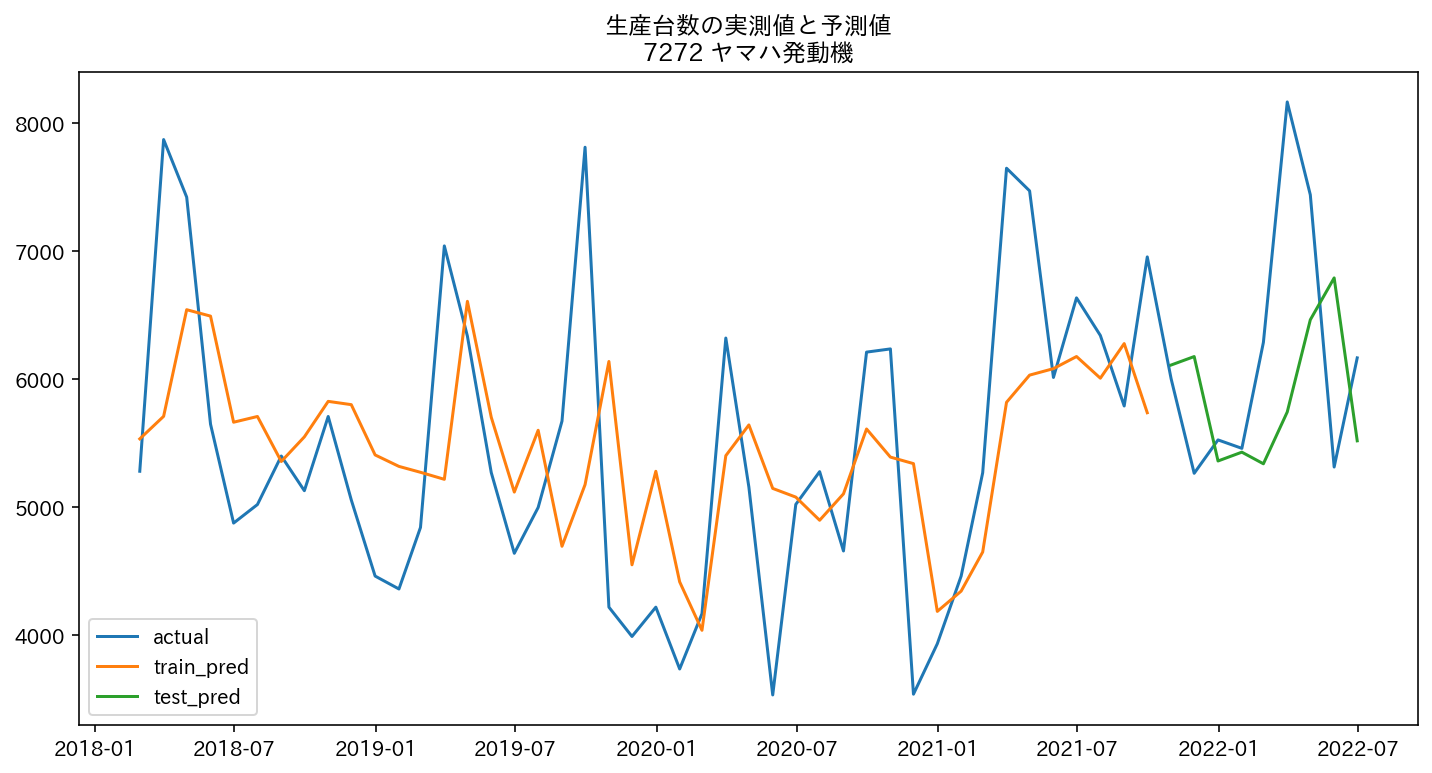

train
R2 = 0.26770125571419656
MAPE = 0.14764873545259094
test
R2 = 3.734046476096491e-05
MAPE = 0.13206004522097184


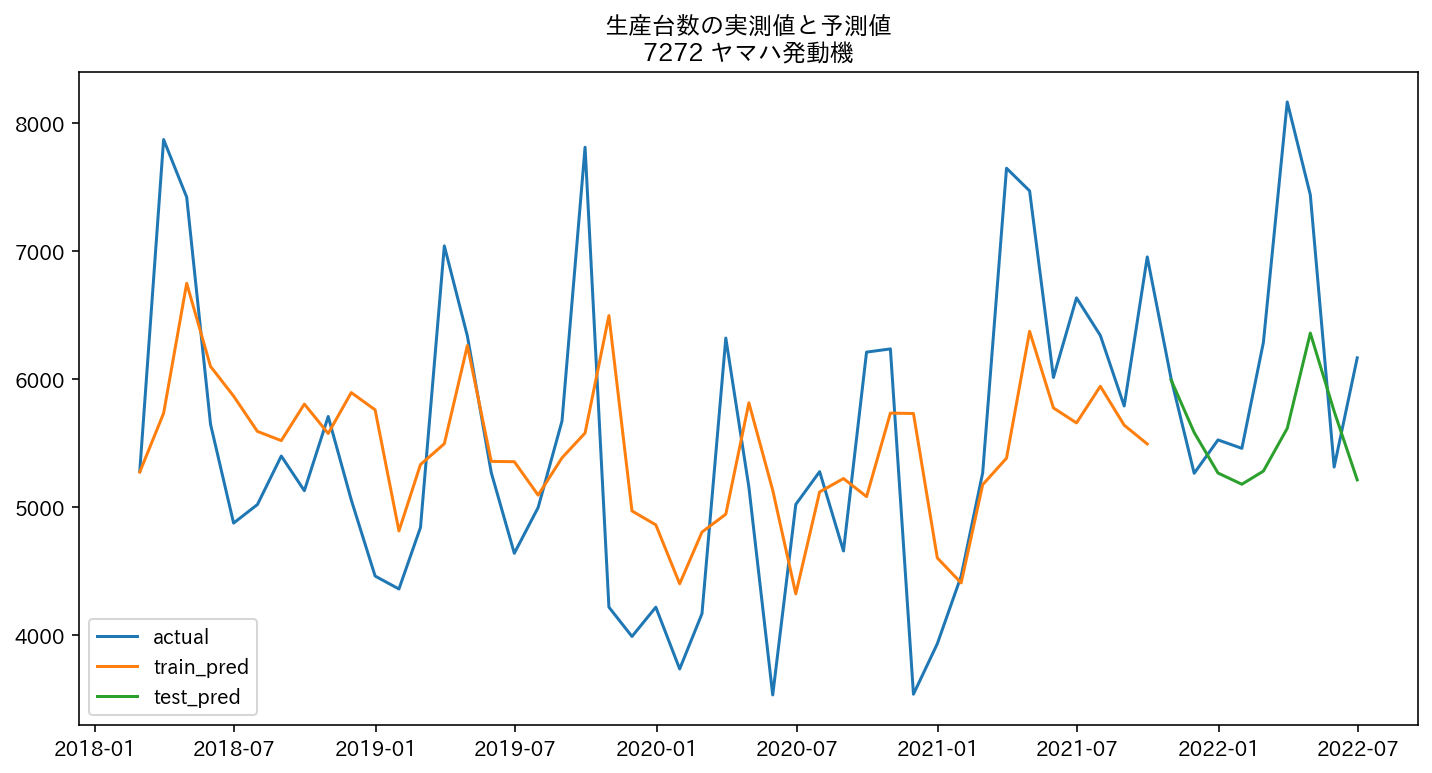

train
R2 = 0.2108085960561158
MAPE = 0.15293271429425545
test
R2 = 0.16102017172419406
MAPE = 0.11273514854834299


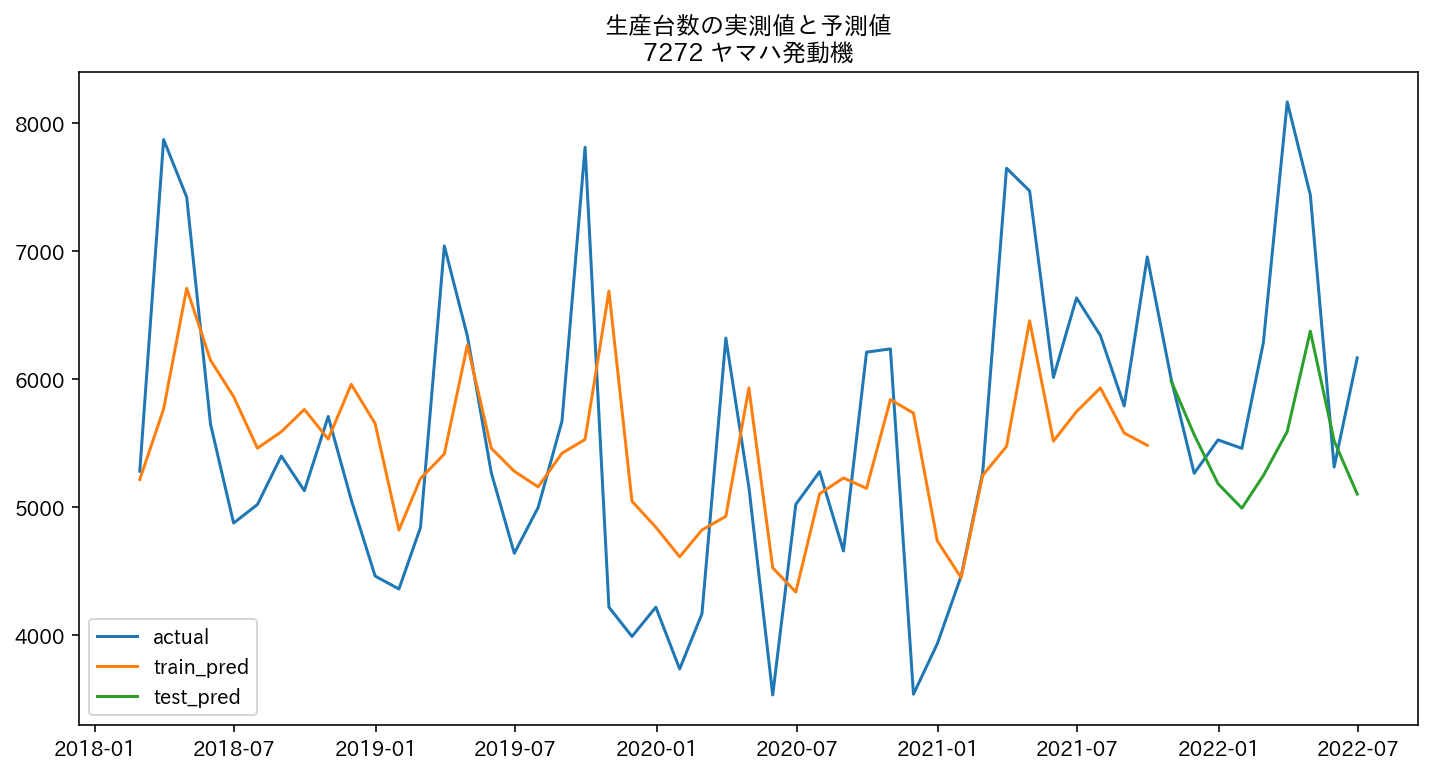

train
R2 = 0.21991354850022715
MAPE = 0.15249838374587524
test
R2 = 0.21628176839591792
MAPE = 0.11586285838993327
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [11]:
for stock_code in [7201, 7203, 7205, 7211, 7267, 7269, 7270, 7272]:
    df_pca, df_pca_w = get_df_pca(stock_code)
    midas_predict(df_pca, 30) # Daily １か月は約３０日
    midas_predict(df_pca_w, 4) # Weekly １か月は約４週
    midas_predict2(df_pca, 4)
    print('-------------------------------------------------------------------------------------------------------------------------------------------------------------------------')